In [1]:
from os import system as bash
from pyspark.sql import SparkSession
from splicemachine.spark import PySpliceContext
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.types import TimestampType
from datetime import datetime
import seaborn as sns
from sklearn.cluster import DBSCAN
import pandas as pd
import numpy as np

/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
splice = PySpliceContext(spark)

In [3]:
SCHEMA = 'AGUPTA'
TABLE = 'smallerjan'

In [150]:
with open('PortNameWithLocDf.csv') as reader:
    for i, line in enumerate(reader):
        print(line)

,Latitude,Longitude,MMSI

" Port Sulphur, USA",29.4741N,89.6838W,367613490

" Port Fourchon, USA",29.1294N,90.2115W,367613490

" Constanta, Romania",44.0922N,28.7116E,477748900

" Nemrut, Turkey",38.7768N,26.909E,477748900

" Marin, Pontevedra, Spain",42.4036N,8.703W,477748900

" Amelia, USA",29.6519N,91.1124W,366967770

" New Orleans, USA",29.95N,90.06W,366967770

" Mobile, USA",30.6651N,88.0298W,366967770

" Los Angeles, USA",33.7163N,118.2644W,367401030

" Long Beach, USA",33.7432N,118.2141W,367401030

" Macapa, Brazil",0.0246N,51.0453W,373871000

" Santana, Brazil",0.0625S,51.1573W,373871000

" Santarem, Brazil",2.4119S,54.7422W,373871000

" Pennsauken, USA",39.9791N,75.0709W,367658140

" Philadelphia, USA",39.95N,75.16W,367658140

" San Francisco, USA",37.8119N,122.4034W,563079000

" Fraser River, Canada",49.1899N,122.9055W,563079000

" Seattle, USA",47.5981N,122.3471W,563079000

" New Orleans, USA",29.95N,90.06W,367472580

" Saint Rose, USA",29.937N,90.3231W,367472580

" West Weg

In [6]:
mmsi_port_loc = {}
mmsi_check = {}
with open('PortNameWithLocDf.csv') as reader:
    for i, line in enumerate(reader):
        if i > 0:
            line = line.split(',')
            mmsi = line[-1][:-1]
            long = float(line[-2][:-1])
            lat = float(line[-3][:-1])
            mmsi_check[mmsi] = line
            
            if mmsi not in mmsi_port_loc:
                mmsi_port_loc[mmsi] = [(lat, long)]
            else:
                mmsi_port_loc[mmsi].append((lat, long))

In [157]:
%%time
%%sql

create index mmsi_index on smallerjan (mmsi)

Sql started successfully



Query executed successfully. Affected rows : 0

CPU times: user 251 ms, sys: 180 ms, total: 431 ms
Wall time: 9min 24s


In [8]:
for mmsi in mmsi_port_loc:
    print(mmsi)
    
    #if mmsi in ['367613490', '477748900', '367613490', '367401030', '373871000', '367658140',
    #            '366967770', '563079000', '367472580', '369293000' ]:
    #    continue
        
    #get data from database
    df = splice.df("select BaseDateTime, Lon, Lat, VesselName from AGUPTA.smallerjan where MMSI = " + mmsi)
    print(df.count())
    
    #convert to pandas, sort according to date times
    trajectory = df.toPandas()
    trajectory = trajectory.sort_values(by=['BASEDATETIME'])
    print(len(trajectory))
    
    #print dates, name
    datelist = list(trajectory['BASEDATETIME'])
    print(datelist[0], datelist[-1])
    name = set(list(trajectory['VESSELNAME']))
    print(name)
    
    #creating datetime objects
    datetime_objects = []
    for date in datelist:
        datetime_objects.append(date)
     
    #creating latitudes and longitudes
    latitude = list(trajectory['LAT'])
    longitude = list(trajectory['LON'])
    traj = []
    for (lat, long) in zip(latitude, longitude):
        traj.append([float(lat), float(long)])
    traj = np.array(traj)

    latitude = [float(lat) for lat in latitude]
    longitude = [float(long) for long in longitude]
    print(max(latitude), min(latitude))
    print(max(longitude), min(longitude))
    
    #finding distance from ports
    lat_sign = np.sign(latitude[0])
    long_sign = np.sign(longitude[0])
    
    ports = []
    for port in mmsi_port_loc[mmsi]:
        lat = port[0] * lat_sign
        long = port[1] * long_sign
        ports.append(np.array([lat, long]))
    print(ports)
    
    #finding viable ports
    distances = []
    distance_limit = 0.002
    valid_ports = 0
    for port in ports:
        d = np.linalg.norm(port - traj, axis = 1)
        if np.min(d) < distance_limit:
            valid_ports += 1
            
    if valid_ports > 0:
        print(mmsi, lat_sign, long_sign)
        print(ports)
        print(mmsi_check[mmsi])
    print('='*20, valid_ports)
    


367613490
22827
22827
2019-01-01 00:00:01 2019-01-01 23:59:55
{'1.4', '8.1', '11.7', '8.4', '5.5', '10.2', '3.0', '0.7', '2.1', '0.1', '0.0', '11.1', '0.2', '1.7', '0.6', '7.9', '1.5', '11.0', '9.0', '10.7', '10.6', '3.6', '6.9', '8.8', '10.4', '11.3', '0.9', '6.2', '10.0', '10.1', '6.6', '11.4', '7.8', '2.0', '0.8', '0.4', '6.7', '11.6', '7.3', '9.8', '8.7', '7.1', '6.5', '2.6', '6.3', '9.4', '8.0', '4.6', '8.5', '-0.1', '4.3', '8.3', '7.7', '7.0', '10.9', '7.4', '11.5', '0.5', '6.0', '9.3', '6.8', '1.0', '8.2', '9.5', '7.6', '4.9', '0.3', '7.5', '9.7', '8.6', '9.2', '2.9', '1.6', '1.9', '7.2', '1.3', '9.9', '11.2', '3.3', '10.5', '10.8', '10.3'}
29.47417 29.17328
-89.25973 -89.68458
[array([ 29.4741, -89.6838]), array([ 29.1294, -90.2115])]
367613490 1.0 -1.0
[array([ 29.4741, -89.6838]), array([ 29.1294, -90.2115])]
['" Port Fourchon', ' USA"', '29.1294N', '90.2115W', '367613490\n']
==================== 1
477748900
16674
16674
2019-01-01 00:00:07 2019-01-01 23:57:26
{'1.4', '8.1', '

IndexError: list index out of range

In [101]:
trajectory = df.toPandas()
trajectory = trajectory.sort_values(by=['BASEDATETIME'])
print(len(trajectory))

17838


In [102]:
datelist = list(trajectory['BASEDATETIME'])
print(datelist[0], datelist[-1])
name = set(list(trajectory['VESSELNAME']))
print(name)

2019-01-01T00:00:01 2019-01-31T23:59:54
{'GREAT EXPECTATIONS'}


In [103]:
datetime_objects = []
for date in datelist:
    datetime_objects.append(datetime.strptime(date, '%Y-%m-%dT%X'))

In [118]:
latitude = list(trajectory['LAT'])
longitude = list(trajectory['LON'])
traj = []
for (lat, long) in zip(latitude, longitude):
    traj.append([float(lat), float(long)])
traj = np.array(traj)
    
latitude = [float(lat) for lat in latitude]
longitude = [float(long) for long in longitude]
print(max(latitude), min(latitude))
print(max(longitude), min(longitude))

29.95952 28.22498
-87.77792 -90.23027


In [112]:
lat_sign = np.sign(latitude[0])
long_sign = np.sign(longitude[0])
ports = []
for port in mmsi_port_loc[mmsi]:
    lat = port[0] * lat_sign
    long = port[1] * long_sign
    ports.append(np.array([lat, long]))

In [149]:
distances = []
distance_limit = 0.002
valid_ports = 0
for port in ports:
    d = np.linalg.norm(port - traj, axis = 1)
    if np.min(d) < distance_limit:
        valid_ports += 1

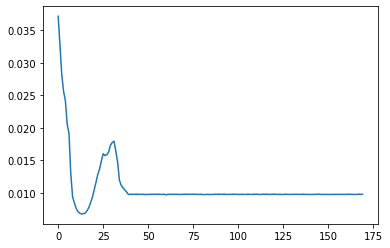

In [148]:
plt.plot(distances[1][14030:14200])

In [115]:
np.array([1,2]) - np.array([[1,2], [20,10]])

array([[  0,   0],
       [-19,  -8]])

In [108]:
port1 = np.array([lat1, long1])
port2 = np.array([lat2, long2])
distance1 = []
distance2 = []
distance_limit = 0.001
out_of_trajectory = 5
for (lat, long) in zip(latitude, longitude):
    d = np.linalg.norm(port1 - np.array([lat, long]))
    distance1.append(d)
    d = np.linalg.norm(port2 - np.array([lat, long]))
    distance2.append(d)

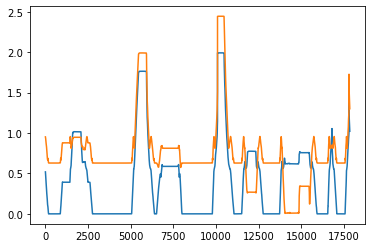

In [107]:
plt.plot(distance1)
plt.plot(distance2)

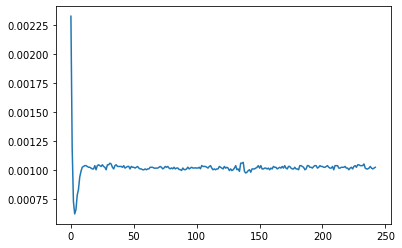

In [85]:
plt.plot(distance[2757:3000])

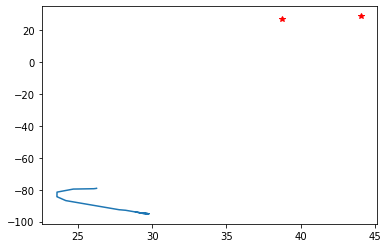

In [99]:
plt.plot(np.array(latitude), np.array(longitude))
plt.plot(lat1, -long1, 'r*')
plt.plot(lat2, -long2, 'r*')

In [41]:
 mmsi_port_loc[mmsi]

[(29.4741, 89.6838), (29.1294, 90.2115)]

In [4]:
df = splice.df("select MMSI from AGUPTA.january")
unique = df.distinct()
unique_mmsi = unique.toPandas()

In [330]:
mmsi = unique_mmsi['MMSI'][50]
print(mmsi)
df = splice.df("select BaseDateTime, Lon, Lat, VesselName from AGUPTA.january where MMSI = " + mmsi)
print(df.count())

538003617
6409


In [20]:
mmsi_freq = pd.read_pickle('Processed_Data/mmsi_freq.pkl')

In [24]:
mmsi_freq['c0'][0]

'316004659'

In [332]:
datelist = list(dates['BASEDATETIME'])
print(datelist[0], datelist[-1])
name = set(list(dates['VESSELNAME']))
print(name)

2019-01-01T00:02:33 2019-01-18T10:17:19
{'DUBAI CHARM'}


In [333]:
datetime_objects = []
for date in datelist:
    datetime_objects.append(datetime.strptime(date, '%Y-%m-%dT%X'))

In [334]:
latitude = list(dates['LAT'])
longitude = list(dates['LON'])
latitude = [float(lat) for lat in latitude]
longitude = [float(long) for long in longitude]
print(max(latitude), min(latitude))
print(max(longitude), min(longitude))

48.51217 29.62833
-117.1549 -126.46973


In [335]:
location = []
for i in range(len(latitude)):
    location.append([latitude[i], longitude[i]])
    
location = np.array(location)

In [337]:
for i in range(10,11):
    print('min_samples =', i)
    clustering = DBSCAN(eps=0.0005, min_samples=i).fit(location)

    labels = clustering.labels_

    #Print number of cluster
    print('Number of clusters:', len(set(list(labels))))
    print('Number of core points:', len(clustering.components_))
    print('Number of Noise Points:', np.sum(labels == -1))
    
    print('Printing size of each label:')
    for label in np.unique(labels):
        print(label , ':', np.sum(labels == label), end = '; ')
    
    print('\n')

min_samples = 10
Number of clusters: 4
Number of core points: 2096
Number of Noise Points: 4292
Printing size of each label:
-1 : 4292; 0 : 957; 1 : 490; 2 : 670; 



In [338]:
len(labels), len(latitude)

(6409, 6409)

0 3562 857.4


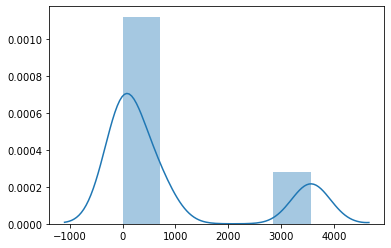

In [339]:
indices = labels == -1
temp = np.diff(indices)
chunks = np.where(temp == True)[0] # tells starting and end of a sequence

paths = []
path_lengths = []
for i in range(0, len(chunks), 2):
    start_index = chunks[i] + 1
    
    if i != len(chunks) - 1:
        end_index = chunks[i+1]
    else:
        end_index = len(labels) - 1
        
    paths.append([start_index, end_index])
    path_lengths.append(end_index-start_index)
        
print(min(path_lengths), max(path_lengths), sum(path_lengths)/len(path_lengths))
sns.distplot(path_lengths)

(array([ 133,  141,  694,  727,  728,  741,  750,  870, 1040, 1104, 1156,
        1227, 3058, 3174]),)

In [310]:
temp[:200]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [302]:
labels[:1000]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,
       -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

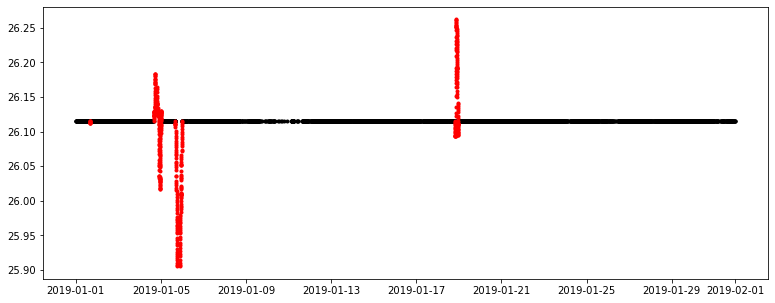

In [303]:
indices = labels == 0
fig = plt.figure(figsize = (13,5))
plt.plot(np.array(datetime_objects)[indices], np.array(latitude)[indices], 'k.')

indices = labels == -1
plt.plot(np.array(datetime_objects)[indices], np.array(latitude)[indices], 'r.')

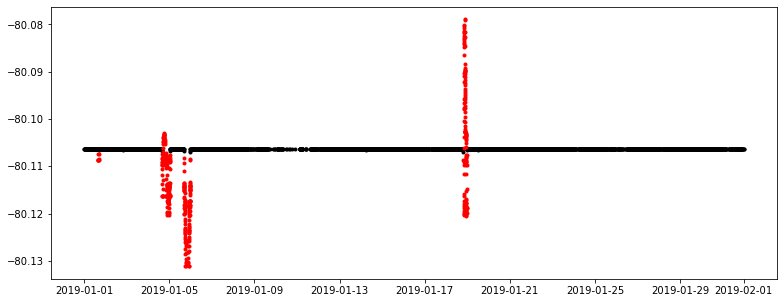

In [304]:
indices = labels == 0
fig = plt.figure(figsize = (13,5))
plt.plot(np.array(datetime_objects)[indices], np.array(longitude)[indices], 'k.')

indices = labels == -1
plt.plot(np.array(datetime_objects)[indices], np.array(longitude)[indices], 'r.')

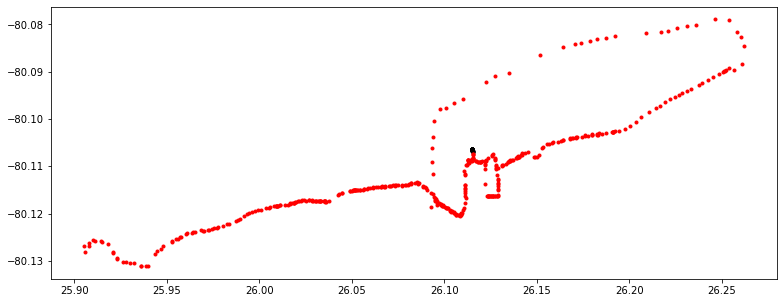

In [324]:
indices = labels == 0
fig = plt.figure(figsize = (13,5))
plt.plot(np.array(latitude)[indices], np.array(longitude)[indices], 'k.')

indices = labels == -1
plt.plot(np.array(latitude)[indices], np.array(longitude)[indices], 'r.')

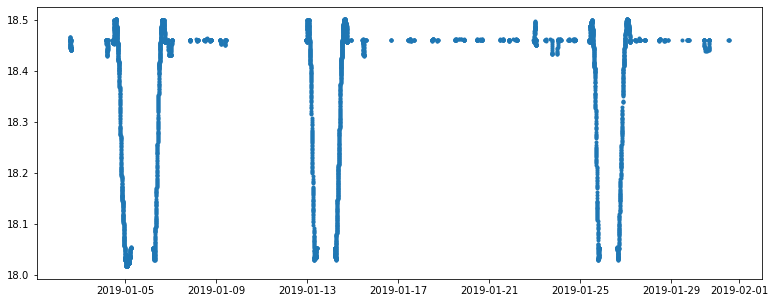

In [240]:
indices = labels == -1
fig = plt.figure(figsize = (13,5))
plt.plot(np.array(datetime_objects)[indices], np.array(latitude)[indices], '.')

Number of clusters: 27
Number of Noise Points: 4293


In [225]:
len(clustering.components_) + np.sum(labels == -1)

26874

In [226]:
location.shape

(27296, 2)

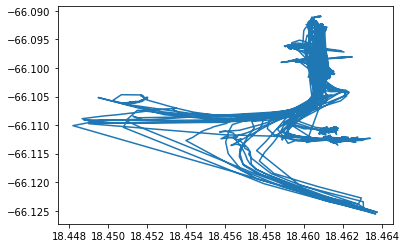

In [163]:
plt.plot(np.array(latitude)[indices], np.array(longitude)[indices])

In [166]:
clustering.core_sample_indices_.shape

(25266,)

In [167]:
location.shape

(27296, 2)

In [127]:
####getting speeds
distance = []
for i in range(1, len(latitude)):
    x = (latitude[i] - latitude[i-1])**2
    y = (longitude[i] - longitude[i-1])**2
    
    distance.append((x+y)**0.5)

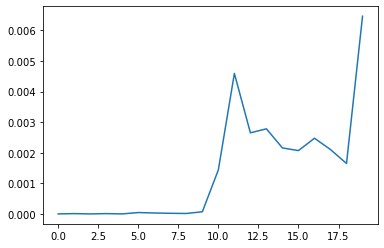

In [131]:
plt.plot(distance[140:160])

In [138]:
dist = np.diff(np.array(distance))

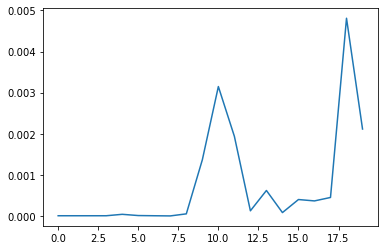

In [140]:
plt.plot(np.abs(dist[140:160]))

In [141]:
dist[140:160]

array([ 1.00000000e-05, -1.00000000e-05,  1.00000000e-05, -1.00000000e-05,
        4.47213595e-05, -1.47213596e-05, -1.00000000e-05, -5.85786438e-06,
        5.58578644e-05,  1.37006944e-03,  3.15062767e-03, -1.94052731e-03,
        1.30279798e-04, -6.24040552e-04, -8.70130050e-05,  4.04083284e-04,
       -3.70695462e-04, -4.54360380e-04,  4.81137527e-03, -2.11817464e-03])

In [122]:
time = []
for i in range(1, len(latitude)):
    time.append((datetime_objects[i] - datetime_objects[i-1]).seconds)

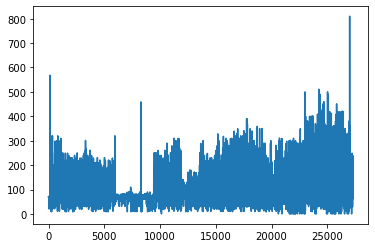

In [123]:
plt.plot(time)

In [126]:
min(time),max(time), np.mean(np.array(time)), np.std(np.array(time))

(0, 810, 93.61263967759663, 45.77165600134406)

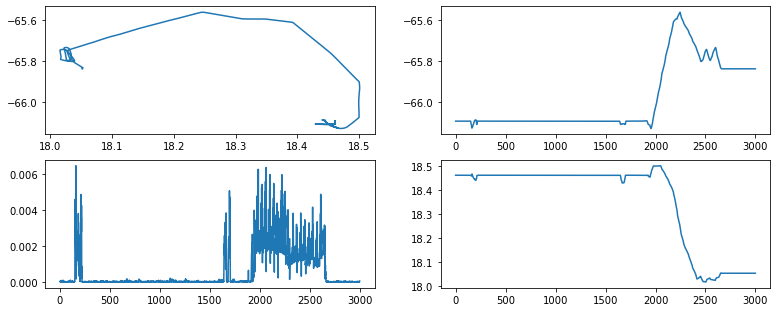

In [192]:
fig = plt.figure(figsize = (13,8))
n = np.arange(0, 3000)

plt.subplot(3, 2, 1)
plt.plot(np.array(latitude)[n], np.array(longitude)[n])

plt.subplot(3, 2, 2)
plt.plot(np.array(longitude)[n])

plt.subplot(3, 2, 3)
plt.plot(np.array(distance)[n])

plt.subplot(3, 2, 4)
plt.plot(np.array(latitude)[n])

#plt.subplot(3, 2, 5)
#plt.plot(np.array(latitude)[n], np.array(longitude)[n], '--')

plt.show()

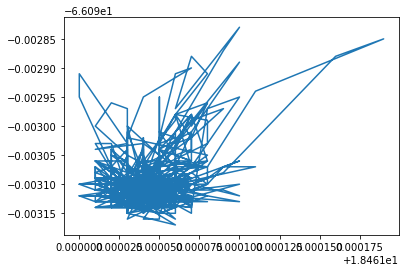

In [187]:
n = np.arange(500, 1500)
plt.plot(np.array(latitude)[n], np.array(longitude)[n])

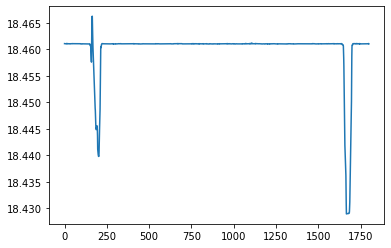

In [184]:
plt.plot(latitude[:n])

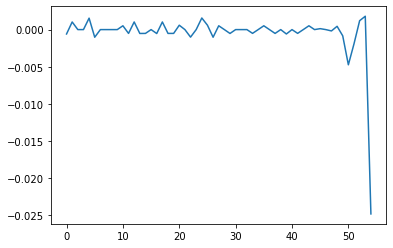

In [121]:
plt.plot(speeds_lat[100:155])

In [152]:
for i in range(10):
    if i < 2:
        continue
    print(i)

2
3
4
5
6
7
8
9


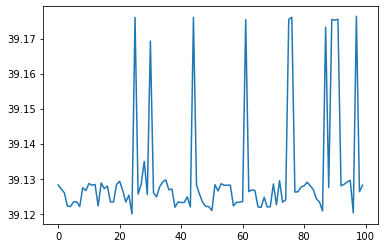

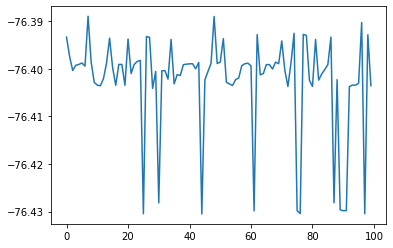

In [63]:
plt.plot(longitude[:100])

In [29]:
datelist[0],datelist[-1] 

('2019-01-01T00:00:06', '2019-01-31T23:59:26')

Help on DataFrame in module pyspark.sql.dataframe object:

class DataFrame(builtins.object)
 |  DataFrame(jdf, sql_ctx)
 |  
 |  A distributed collection of data grouped into named columns.
 |  
 |  A :class:`DataFrame` is equivalent to a relational table in Spark SQL,
 |  and can be created using various functions in :class:`SparkSession`::
 |  
 |      people = spark.read.parquet("...")
 |  
 |  Once created, it can be manipulated using the various domain-specific-language
 |  (DSL) functions defined in: :class:`DataFrame`, :class:`Column`.
 |  
 |  To select a column from the data frame, use the apply method::
 |  
 |      ageCol = people.age
 |  
 |  A more concrete example::
 |  
 |      # To create DataFrame using SparkSession
 |      people = spark.read.parquet("...")
 |      department = spark.read.parquet("...")
 |  
 |      people.filter(people.age > 30).join(department, people.deptId == department.id) \
 |        .groupBy(department.name, "gender").agg({"salary": "avg", "age